In [1]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
# import the libraries as shown below
import gradio as gr
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
# import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/drive/MyDrive/Datasets/train'
valid_path = '/content/drive/MyDrive/Datasets/val'

In [6]:
# Here we will be using imagenet weights
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [7]:
# don't train existing weights
for layer in resnet.layers:
    layer.trainable = False

In [8]:
# useful for getting number of output classes
folders = glob('/content/drive/MyDrive/Datasets/train/*')

In [9]:
# our layers - you can add more if you want
x = Flatten()(resnet.output)

In [10]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=resnet.input, outputs=prediction)

In [11]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [12]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [13]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [14]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

valid_set = train_datagen.flow_from_directory(valid_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1951 images belonging to 4 classes.
Found 324 images belonging to 4 classes.


In [15]:
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Datasets/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 18 images belonging to 4 classes.


In [16]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit(
  training_set,
  validation_data=valid_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set)
)

Epoch 1/20
61/61 [==============================] - 394s 6s/step - loss: 2.6457 - accuracy: 0.3895 - val_loss: 1.4063 - val_accuracy: 0.5370
Epoch 2/20
61/61 [==============================] - 36s 587ms/step - loss: 1.0123 - accuracy: 0.5848 - val_loss: 0.9325 - val_accuracy: 0.6512
Epoch 3/20
61/61 [==============================] - 35s 580ms/step - loss: 1.0694 - accuracy: 0.5971 - val_loss: 0.8506 - val_accuracy: 0.6914
Epoch 4/20
61/61 [==============================] - 35s 578ms/step - loss: 0.8861 - accuracy: 0.6412 - val_loss: 1.0053 - val_accuracy: 0.6111
Epoch 5/20
61/61 [==============================] - 36s 585ms/step - loss: 1.0242 - accuracy: 0.6279 - val_loss: 0.6748 - val_accuracy: 0.7562
Epoch 6/20
61/61 [==============================] - 35s 578ms/step - loss: 0.8541 - accuracy: 0.6540 - val_loss: 1.5869 - val_accuracy: 0.5000
Epoch 7/20
61/61 [==============================] - 36s 588ms/step - loss: 0.7225 - accuracy: 0.7125 - val_loss: 0.6634 - val_accuracy: 0.7191
E

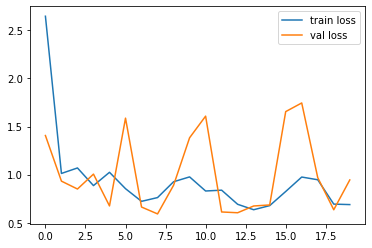

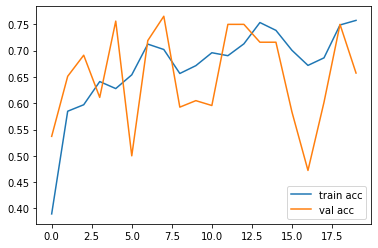

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [19]:
test_imgs, test_labels = next(test_set)
predictions = model.predict(x=test_set, steps=len(test_set), verbose=0)

In [20]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=test_set.classes, y_pred=np.argmax(predictions, axis=-1))

In [34]:
test_set.class_indices

{'diseased cotton leaf': 0,
 'diseased cotton plant': 1,
 'fresh cotton leaf': 2,
 'fresh cotton plant': 3}

In [23]:
import itertools

Confusion matrix, without normalization
[[0 0 3 0]
 [1 2 1 1]
 [1 1 0 3]
 [0 4 1 0]]


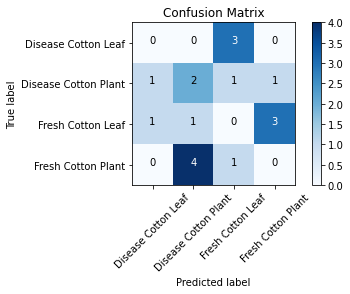

In [24]:
cm_plot_labels = ['Disease Cotton Leaf','Disease Cotton Plant', 'Fresh Cotton Leaf', 'Fresh Cotton Plant']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [26]:
# save it as a h5 file
from tensorflow.keras.models import load_model
model.save('model_resnet50.h5')

In [31]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_ds = image_dataset_from_directory(
  train_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(224, 224),
  batch_size=32)

Found 1951 files belonging to 4 classes.
Using 1561 files for training.


In [32]:
class_names = train_ds.class_names
print(class_names)

['diseased cotton leaf', 'diseased cotton plant', 'fresh cotton leaf', 'fresh cotton plant']


In [25]:
def predict_image(img):
  img_4d=img.reshape(-1,224,224,3)
  prediction=model.predict(img_4d)[0]
  return {class_names[i]: float(prediction[i]) for i in range(4)}

In [ ]:
image = gr.inputs.Image(shape=(224,224))
label = gr.outputs.Label(num_top_classes=4)

gr.Interface(fn=predict_image, inputs=image, outputs=label, interpretation='default').launch(debug='True')

/usr/local/lib/python3.7/dist-packages/gradio/inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  "Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components",
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.7/dist-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  "Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components",
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
 

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://5caef4d0226ec08e.gradio.app

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
